In [1]:
import torch
import sys
import os
sys.path.append(os.environ["LATENT_PATH"])
import pickle
from auto_localization.experiment_management.basic_experiment import BasicExperiment
from auto_localization.dataset_management.data_manager import DataManager
from datasets.morpho_mnist.dataset import MetadataDataset, ImageDataset, TripletDataset
from auto_localization.oracles.metadata_oracle import MetadataOracle
from auto_localization.oracles.indexed_metadata_oracle import IndexedMetadataOracle
from auto_localization.oracles.indexed_class_oracle import IndexedClassOracle
from auto_localization.oracles.oracle import EnsembleOracle
from datasets.morpho_mnist.measure import measure_image
from auto_localization.models.loss.masked_vae_triplet_loss import MaskedVAETripletLoss
import numpy as np
from tqdm import tqdm


### Get MCMV Localization Queries

In [2]:
# load the model 
# run_name = "rosy-smoke-134"
run_name = "blooming-hill-217"
# load up the experiment parameters from the given run_name
run_directory = os.path.join(os.environ["LATENT_PATH"], "auto_localization", "logs", run_name)
# load the expeirment config
params_path = run_directory + "/params.pkl"
with open(params_path, "rb") as f:
    experiment_config = pickle.load(f)
# make the experiment
basic_experiment = BasicExperiment(experiment_config=experiment_config, do_setup=False)
basic_experiment.load_data(run_directory)
# get the model
model = basic_experiment.model
localizers = basic_experiment.localization_experiment_manager.localizers

Setting Up Logging
Setup Model Config
Setting Up Model
IsolatedVAE(
  (loss_function): IsolatedTripletLoss(
    (empty_linear): Linear(in_features=1, out_features=1, bias=True)
    (triplet_margin_loss): TripletMarginLoss()
  )
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv4_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (similarity_mean_linear): Linear(in_features=1024, out_features=4, bias=True)
  (s

### Get Triplet Dataset Queries


In [3]:
which_digits=[1]
component_weighting = [1.0, 0.0, 1.0, 1.0, 1.0, 0.0]
one_two_ratio = 0.0
attribute_return = True

metadata_dataset = MetadataDataset(
    train=True, 
    which_digits=which_digits
)
metadata_oracle = IndexedMetadataOracle(
    metadata_dataset=metadata_dataset,
    component_weighting=component_weighting,
)
# setup data manager
triplet_train_dataset = TripletDataset(
    train=True,
    which_digits=which_digits,
    oracle=metadata_oracle,
    one_two_ratio=one_two_ratio,
    attribute_return=attribute_return, 
    single_feature_triplet=True
) 

### Evaluate The Percentage Satisfied

In [4]:
def triplet_forward(model, triplet):
    anchor, positive, negative, attribute_index = triplet
    _, _, anchor_z, _ = model.forward(anchor.cuda())
    _, _, positive_z, _ = model.forward(positive.cuda())
    _, _, negative_z, _ = model.forward(negative.cuda())
    
    return anchor_z, positive_z, negative_z, attribute_index

def is_satisfied(model, triplet, images=True):
    if images:
        anchor_z, positive_z, negative_z, attribute_index = triplet_forward(model, triplet)
        return model.loss_function.triplet_percentage(anchor_z, positive_z, negative_z, [attribute_index])
    else:
        anchor_z, positive_z, negative_z, attribute_index = triplet
        anchor_positive = torch.norm(anchor_z - positive_z)
        anchor_negative = torch.norm(anchor_z - negative_z)
        return 1.0 if anchor_positive < anchor_negative else 0.0

def percentage_satisfied(model, triplets, images=True):
    num_satisfied = 0
    loss = MaskedVAETripletLoss()
        
    for triplet in tqdm(triplets):
        num_satisfied += is_satisfied(model, triplet, images=images)
            
    return num_satisfied / len(triplets)

In [5]:
from enum import Enum
"""
    Enum of noise constant types
"""
class KNormalizationType(Enum):
    CONSTANT = 0
    NORMALIZED = 1
    DECAYING = 2

def pair2hyperplane(positive_z, negative_z, normalization):
    A_emb = 2*(positive_z - negative_z)
    if np.linalg.norm(A_emb) == 0:
        A_emb = np.ones_like(positive_z)*0.000001
    tau_emb = (np.linalg.norm(positive_z)**2 - np.linalg.norm(negative_z)**2)
    if normalization is KNormalizationType.CONSTANT:
        pass
    elif normalization is KNormalizationType.NORMALIZED:
        A_mag = np.linalg.norm(A_emb)
        A_emb = A_emb / A_mag
        tau_emb = tau_emb / A_mag
    elif normalization is KNormalizationType.DECAYING:
        A_mag = np.linalg.norm(A_emb)
        A_emb = A_emb * np.exp(-A_mag)
        tau_emb = tau_emb * np.exp(-A_mag)
    
    return (A_emb, tau_emb)

def calculate_logistic_probability(anchor_z, positive_z, negative_z, k=1.0, normalization=KNormalizationType.CONSTANT):
    anchor_z = anchor_z.detach().cpu().numpy()
    positive_z = positive_z.detach().cpu().numpy()
    negative_z = negative_z.detach().cpu().numpy()
    def logistic_function(val):
        return 1 / (1 + np.exp(-val))
    
    A_emb, tau_emb = pair2hyperplane(positive_z, negative_z, normalization=normalization)
    probability = logistic_function(k *
        np.dot(A_emb, anchor_z) - tau_emb
    )
    return probability

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# Sample 2500 triplet queries
num_triplets = 5000
triplets = []
for i in tqdm(range(num_triplets)):
    triplet, _ = triplet_train_dataset[i]
    anchor_z, positive_z, negative_z, _ = triplet_forward(model, triplet)
    triplets.append((anchor_z, positive_z, negative_z))

100%|██████████| 5000/5000 [00:36<00:00, 138.29it/s]


100%|██████████| 100/100 [00:31<00:00,  3.19it/s]

6.940873693670064
[0.65019311 0.65024824 0.65030133 0.65035226 0.65040091 0.6504472
 0.65049105 0.65053242 0.6505713  0.6506077  0.65064165 0.6506732
 0.65070241 0.65072937 0.65075416 0.65077685 0.65079753 0.65081627
 0.65083314 0.65084819 0.65086147 0.65087299 0.6508828  0.65089091
 0.65089734 0.65090212 0.65090527 0.65090686 0.65090694 0.6509056
 0.65090294 0.65089908 0.65089419 0.65088843 0.65088197 0.65087501
 0.65086775 0.65086035 0.650853   0.65084585 0.65083901 0.65083258
 0.65082661 0.6508211  0.65081602 0.65081129 0.6508068  0.65080238
 0.65079787 0.65079303 0.65078765 0.65078148 0.65077427 0.65076579
 0.65075578 0.65074402 0.65073032 0.65071449 0.65069638 0.65067587
 0.65065286 0.65062729 0.65059913 0.65056837 0.65053502 0.65049914
 0.65046077 0.65041998 0.65037686 0.65033148 0.65028394 0.65023433
 0.65018274 0.65012925 0.65007397 0.65001697 0.64995834 0.64989818
 0.64983657 0.64977361 0.6497094  0.64964404 0.64957765 0.64951034
 0.64944225 0.6493735  0.64930425 0.64923463 0.

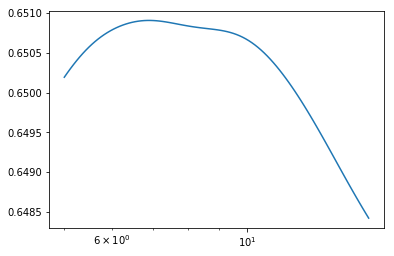

In [14]:
# k settings
ks = np.logspace(0.7, 1.2, num=100)
normalization = KNormalizationType.CONSTANT
# probability 
probabilities = []
for k in tqdm(ks):
    k_probs = []
    for triplet in triplets:
        anchor_z, positive_z, negative_z = triplet
        probability = calculate_logistic_probability(anchor_z, positive_z, negative_z, k=k, normalization=normalization)
        k_probs.append(probability)
    probabilities.append(k_probs)
probabilities = np.array(probabilities)
probabilities = np.mean(probabilities, axis=1)
print(ks[np.argmax(probabilities)])
print(probabilities)
fig, axs = plt.subplots(1, 1)
axs.set_xscale("log")
axs.plot(ks, probabilities)

### Measure the average probability that triplets are satisfied

In [ ]:
--------------------------------------------------------------

Is there a difference between the percentage satisfied for MCMV triplets and Triplet Dataset triplets?

What is the spread of the triplets in each dataset?

In [5]:
# load the model 
run_name = "cosmic-lake-8978"
# load up the experiment parameters from the given run_name
run_directory = os.path.join(os.environ["LATENT_PATH"], "auto_localization", "logs", run_name)
# load the expeirment config
params_path = run_directory + "/params.pkl"
with open(params_path, "rb") as f:
    experiment_config = pickle.load(f)
# make the experiment
basic_experiment = BasicExperiment(experiment_config=experiment_config, do_setup=False)
basic_experiment.load_data(run_directory)
# get the model
model = basic_experiment.model

Setting Up Logging
Setup Model Config
Setting Up Model
MaskedVAE(
  (loss_function): BayesianTripletLoss(margin=0.0000)
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv4_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=20, bias=True)
  (fc2): Linear(in_features=1024, out_features=20, bias=True)
  (d1): Linear(in_features=20, out_features=1024, bias=True)
  (deco

In [8]:
num_queries = 50
mcmv_triplets = []
for localizer in tqdm(localizers):
    embedded_reference = localizer.embedded_reference
    for query_index in range(num_queries):
        query = localizer.queries[query_index]
        choice = localizer.choices[query_index]
        attribute_index = -1
        if choice == 1:
            positive = query[0]
            negative = query[1]
        else:
            positive = query[1]
            negative = query[0]
        triplet = embedded_reference, positive, negative, attribute_index
        mcmv_triplets.append(triplet)

0it [00:00, ?it/s]


In [6]:
print("Percentage of triplets satisfied from the MCMV queries")
print(percentage_satisfied(model, mcmv_triplets, images=False))
print("Percentage of triplets satisfied from the dataset")
print(percentage_satisfied(model, dataset_triplets, images=True))

Percentage of triplets satisfied from the MCMV queries


NameError: name 'mcmv_triplets' is not defined

### kNN Experiment
This is where I will perform the k-nearest neighbor performance. I want to predict whether or not a query will be inconsistent based on its latent vectors.

### Distance Metric
First we want to make some distance metric over the space of query pairs. I want this metric to be symetric so it will be the average of the permuations of the latent vectors.

In [7]:

def make_metric(latent_dim=10):
    """
        Query_a and query_b are tuples of latent vectors
    """
    def query_distance(query_a, query_b):
        # turn the queries into tuples based on latent_dim
        query_a = (query_a[0:latent_dim], query_a[latent_dim:])
        query_b = (query_b[0:latent_dim], query_b[latent_dim:])
        # first 
        a = np.concatenate(query_a)
        b = np.concatenate(query_b)
        dist_1 = np.linalg.norm(a - b)
        # second
        query_a = (query_a[1], query_a[0])
        a = np.concatenate(query_a)
        b = np.concatenate(query_b)
        dist_2 = np.linalg.norm(a - b)
        # third
        query_a = (query_a[1], query_a[0])
        query_b = (query_b[1], query_b[0])
        a = np.concatenate(query_a)
        b = np.concatenate(query_b)
        dist_3 = np.linalg.norm(a - b)
        # fourth
        query_a = (query_a[1], query_a[0])
        a = np.concatenate(query_a)
        b = np.concatenate(query_b)
        dist_4 = np.linalg.norm(a - b)

        return (dist_1 + dist_2 + dist_3 + dist_4) / 4
    
    return query_distance

query_distance = make_metric(model.z_dim)
    

Now I want to load up all of the data so that I can train a kNN classifier

In [8]:
triplet_train_dataset = TripletDataset(
    train=True,
    which_digits=which_digits,
    oracle=metadata_oracle,
    one_two_ratio=one_two_ratio,
    attribute_return=attribute_return, 
    single_feature_triplet=True
) 
triplet_test_dataset = TripletDataset(
    train=False,
    which_digits=which_digits,
    oracle=metadata_oracle,
    one_two_ratio=one_two_ratio,
    attribute_return=attribute_return, 
    single_feature_triplet=True
) 

In [18]:
# a function that takes a given triplet dataset and generates a set of samples 
def generate_dataset(triplet_dataset, model, num_samples = 3000, apply_augmentation=True):
    input_datas = []
    labels = []
    for sample_index in tqdm(range(num_samples)):
        # sample a triplet
        triplet, _ = triplet_dataset[sample_index]
        # map the triplet to latent space using the model
        z_triplet = triplet_forward(model, triplet)
        anchor_z, positive_z, negative_z, attribute_index = z_triplet
        positive_z = positive_z.detach().cpu().numpy().squeeze()
        negative_z = negative_z.detach().cpu().numpy().squeeze()
        input_data = np.concatenate((positive_z, negative_z))
        assert len(np.shape(input_data)) == 1
        input_datas.append(input_data)
        # evalaute whether or not the triplet is satisfied
        is_sat = is_satisfied(model, z_triplet, images=False)
        labels.append(is_sat)
        if apply_augmentation:
            input_data = np.concatenate((negative_z, positive_z))
            input_datas.append(input_data)
            labels.append(is_sat)
        
    input_datas = np.stack(input_datas)
    return input_datas, labels

In [19]:
train_dataset = generate_dataset(triplet_train_dataset, model, num_samples=10000)
test_dataset = generate_dataset(triplet_test_dataset, model, num_samples=3000)
print("datasets loaded")

100%|██████████| 3000/3000 [00:21<00:00, 139.44it/s]

datasets loaded


In [20]:
print(train_dataset[0])

[[-3.1979775  -0.64267576 -2.1034284  ...  0.3887502  -0.9398258
   0.6163217 ]
 [ 2.4278715  -1.853126   -0.22120021 ... -0.8391863   0.20057437
   0.5431137 ]
 [ 1.1877067   1.3491385  -0.6242293  ...  0.5962732   0.13909605
   0.33599135]
 ...
 [-3.2135215   2.9569976   0.75330424 ... -0.26744425  0.2001259
  -0.5601714 ]
 [-0.7917098  -1.3705251   0.5496073  ... -1.1677226   0.6114422
   0.97310245]
 [-0.99062216  1.090662    0.26825505 ...  0.8107096  -1.8223858
  -0.5405943 ]]


In [21]:
# how balanced is the dataset
print(np.sum(train_dataset[1]) / len(train_dataset[1]))

0.6798


Setup sklearn k-nn classifier 

In [29]:
from sklearn.neighbors import KNeighborsClassifier

n_neighbors = 20
knn_classifier = KNeighborsClassifier(metric=query_distance, n_neighbors=n_neighbors, p=1)
input_datas, labels = train_dataset
knn_classifier.fit(input_datas, labels)
# evaluate the classifier
input_datas, labels = test_dataset
print(knn_classifier.score(input_datas, labels))

KeyboardInterrupt: 

In [30]:
from sklearn.neural_network import MLPClassifier

mlp_classifier = MLPClassifier(hidden_layer_sizes=(20, 20, 20))
input_datas, labels = train_dataset
mlp_classifier.fit(input_datas, labels)
print("train error")
print(mlp_classifier.score(input_datas, labels))
input_datas, labels = test_dataset
print("test error")
print(mlp_classifier.score(input_datas, labels))

train error
0.71825
test error
0.5068333333333334


/home/alec/anaconda3/envs/latent/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.62
